# Task 2: Coordinate Transformations

In this notebook we will use what we have learned about marker detection in the last notebook

## Imports

In [ ]:
# install opencv
!pip install opencv-python --break-system-packages
!pip install opencv-contrib-python --break-system-packages


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
# imports
import cv2
from matplotlib import pyplot as plt
import numpy as np
import yaml
import io

## Setup

We again load the camera parameters. This time not only need them for preprocessing our image, but we will also use them when estimating where the markers are relative to the camera.

In [2]:
# load camera parameters
with open("./cv-course-robot-viewer-main/robot-code/camera_intrinsics_new_camera.yml", 'r') as stream:
    camera_intrinsics = yaml.safe_load(stream)
camera_matrix = np.array(camera_intrinsics["camera_matrix"]["data"]).reshape((3,3))
distortion_coefficients = np.array(camera_intrinsics["distortion_coefficients"]["data"])

The other component for estimating the markers' poses and postions we need to know beforehand, is the size of our markers.

In [3]:
# set marker size
marker_size = 0.05

## Detect Aruco Markers

**Task:** Use the *cv2.aruco.DICT_ARUCO_ORIGINAL* dictionary for detecting the markers in the given image. 

**Note:** In this specific case, you don't have to undistort the image after loading it, because the function that handles the marker pose estimation (*solvePnP*, which we will use in the next task) will do that internally. So you just have to detect the markers in the undistorted image, image distortions will be accounted for post detection.

**Note:** The list that contains the marker ids should be named *ids*, in order for the provided code to run without changes.

Detected 3 markers: [  1   5 405]


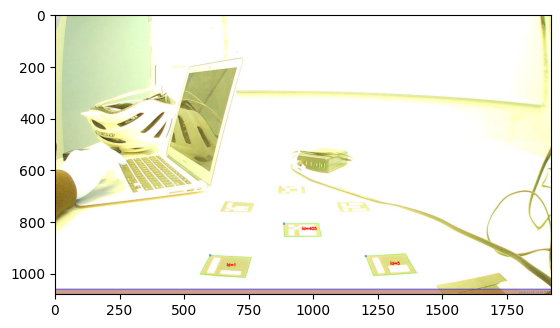

In [4]:
# load image
img = cv2.imread("./cv-course-robot-viewer-main/robot-code/notebooks/2025-11-17_14-30-00/image.jpg")

### Your code here ###

# setup detector
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_ARUCO_ORIGINAL)
parameters = cv2.aruco.DetectorParameters()


# detect markers in the image
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)
corners, ids, rejected = detector.detectMarkers(img)


# draw markers onto the image
img_with_markers = cv2.aruco.drawDetectedMarkers(img.copy(), corners, ids)
print(f"Detected {len(ids)} markers: {ids.flatten()}")


plt.imshow(img_with_markers)

## Pose Estimation

**Task:** Use OpenCV's *solvePnP* function to estimate the poses of the markers detected in the previous task. 

**Note:** The function should get the camera matrix and distortion parameters as arguments, because it internally handles the *undistortion* step that we did separately in the last notebook.

[ WARN:0@60.262] global solvepnp.cpp:123 drawFrameAxes Some of projected axes endpoints are out of frame. The drawn axes may be not reliable.


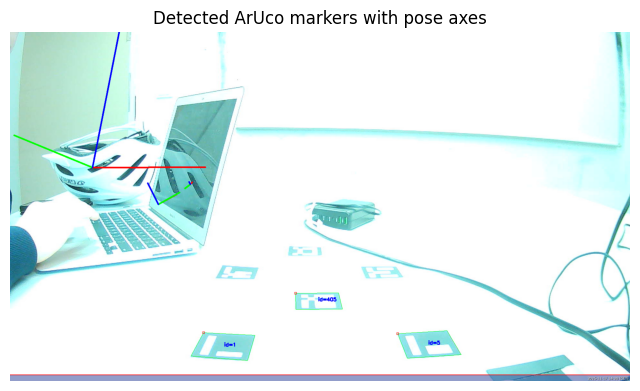

In [6]:
# estimate marker poses using the detected marker corners from the image, the camera parameters, and the (known) size of the marker 
marker_rvecs = []
marker_tvecs = []

# marker corners
marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                          [marker_size / 2, marker_size / 2, 0],
                          [marker_size / 2, -marker_size / 2, 0],
                          [-marker_size / 2, -marker_size / 2, 0]])

with open("./cv-course-robot-viewer-main/robot-code/camera_intrinsics_new_camera.yml", 'r') as stream:
    camera_intrinsics = yaml.safe_load(stream)
camera_matrix = np.array(camera_intrinsics["camera_matrix"]["data"]).reshape((3,3))
distortion_coefficients = np.array(camera_intrinsics["distortion_coefficients"]["data"])


# --- Estimate pose for each detected marker ---
for i in range(len(ids)):
    success, rvec, tvec = cv2.solvePnP(
        marker_points,
        corners[i][0],
        camera_matrix,
        distortion_coefficients
    )
    if success:
        marker_rvecs.append(rvec)
        marker_tvecs.append(tvec)

        # Draw the 3D axis on the image
        cv2.drawFrameAxes(img_with_markers, camera_matrix, distortion_coefficients, rvec, tvec, marker_size * 0.5)

# --- Show result ---
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(img_with_markers, cv2.COLOR_BGR2RGB))
plt.title("Detected ArUco markers with pose axes")
plt.axis("off")
plt.show()

**Task:** Use OpenCV's *drawFrameAxes* function to visualise the estimated marker poses.

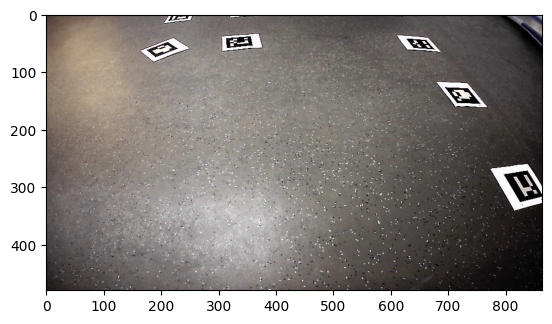

In [98]:
# visualise the estimated marker poses in the image
img_axis = img.copy()
### Your code here ###

###

plt.imshow(img_axis)

## Projecting Aruco Marker Positions to Robot and World Frame

In [7]:
def rotation_matrix(x_rotation, y_rotation, z_rotation):
    alpha = z_rotation
    beta = y_rotation
    gamma = x_rotation

    # https://en.wikipedia.org/wiki/Rotation_matrix
    # rotates around z, then y, then x

    return np.array([
        [np.cos(alpha)*np.cos(beta), np.cos(alpha)*np.sin(beta)*np.sin(gamma)-np.sin(alpha)*np.cos(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)+np.sin(alpha)*np.sin(gamma)],
        [np.sin(alpha)*np.cos(beta), np.sin(alpha)*np.sin(beta)*np.sin(gamma)+np.cos(alpha)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma)-np.cos(alpha)*np.sin(gamma)],
        [-np.sin(beta), np.cos(beta)*np.sin(gamma), np.cos(beta)*np.cos(gamma)]
    ])

In [8]:
def vectors_to_transformation_matrix(rotation, translation):
    """
    Convert rotation and translation vector
    into a 4x4 homogeneous transformation matrix.
    Apparently there is a Rodrigues function in OpenCV that can help with this specifically for the solvePnP output.
    """
    rotation = np.asarray(rotation).reshape(-1)
    translation = np.asarray(translation).reshape(3, 1)

    # Check if we got a Rodrigues vector (from solvePnP)
    if rotation.shape == (3,):
        R, _ = cv2.Rodrigues(rotation)
    elif rotation.shape == (3, 3):
        R = rotation
    else:
        raise ValueError("Rotation must be either a Rodrigues vector or 3x3 matrix.")

    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = translation.flatten()
    return T

In [9]:
def transformation_matrix_to_vectors(T):
    """
    Convert a 4x4 homogeneous transformation matrix into rotation
    and translation vectors.
    """
    R = T[:3, :3]
    translation = T[:3, 3]

    # --- Extract Euler angles (ZYX convention) ---
    sy = np.sqrt(R[0, 0]**2 + R[1, 0]**2)
    angle_too_small = sy < 1e-6

    if not angle_too_small:
        x_rotation = np.arctan2(R[2, 1], R[2, 2])
        y_rotation = np.arctan2(-R[2, 0], sy)
        z_rotation = np.arctan2(R[1, 0], R[0, 0])
    else:
        # Gimbal lock case
        x_rotation = np.arctan2(-R[1, 2], R[1, 1])
        y_rotation = np.arctan2(-R[2, 0], sy)
        z_rotation = 0

    return np.array([x_rotation, y_rotation, z_rotation]), translation


### Projecting to robot frame

In [102]:
# offset from camera to robot frame
x_offset_camera = 0.03
y_offset_camera = 0
z_offset_camera = 0.175

offset_camera_robot = np.array([x_offset_camera,y_offset_camera,z_offset_camera]) 

In [ ]:
# angle from camera to robot frame
x_angle_camera = 0 #degrees
y_angle_camera = 0
z_angle_camera = -100 #degrees

rotation_camera_robot = np.array([np.radians(x_angle_camera), np.radians(y_angle_camera), np.radians(z_angle_camera)])

**Task:** Create transform matrix from camera frame to robot frame.

In [104]:
### Your code here ###

R_cam_robot = rotation_matrix(*rotation_camera_robot)
T_camera_robot = np.eye(4)
T_camera_robot[:3, :3] = R_cam_robot
T_camera_robot[:3, 3] = offset_camera_robot
print("T_camera_robot:\n", T_camera_robot)

T_camera_robot:
 [[ 6.12323400e-17 -7.66044443e-01  6.42787610e-01  3.00000000e-02]
 [-1.00000000e+00 -4.69066938e-17  3.93593894e-17  0.00000000e+00]
 [-0.00000000e+00 -6.42787610e-01 -7.66044443e-01  2.80000000e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


**Task:** Create transform matrices for all markers, project them into the robot coordinate frame, and transform the resulting matrices back into rotation and translation vectors. Also print the id and world position for each marker.

In [105]:
# create transform matrices for all markers, project them into the robot coordinate frame
# transform them to rotation and translation vectors
marker_rvecs_robot = []
marker_tvecs_robot = []

for i, (rvec, tvec) in enumerate(zip(marker_rvecs, marker_tvecs)):
    T_marker_cam = vectors_to_transformation_matrix(rvec, tvec)
    T_marker_robot = T_camera_robot @ T_marker_cam  # compose transform
    rvec_robot, tvec_robot = transformation_matrix_to_vectors(T_marker_robot)
    marker_rvecs_robot.append(rvec_robot)
    marker_tvecs_robot.append(tvec_robot)
    print(f"Marker ID {ids[i][0]}: position (robot frame) = {tvec_robot.round(3)} m")


###

Marker ID 548: position (robot frame) = [ 0.663  0.125 -0.099] m
Marker ID 863: position (robot frame) = [ 0.65   0.288 -0.097] m
Marker ID 860: position (robot frame) = [ 0.487 -0.28  -0.086] m
Marker ID 650: position (robot frame) = [ 0.708 -0.265 -0.121] m


Now, let us visualise the results of our pose estimation. We start with a visualisation of where the detected markers are, realitve to our robot, on the vertical plane. 

Text(0.5, 1.0, 'vertical plane')

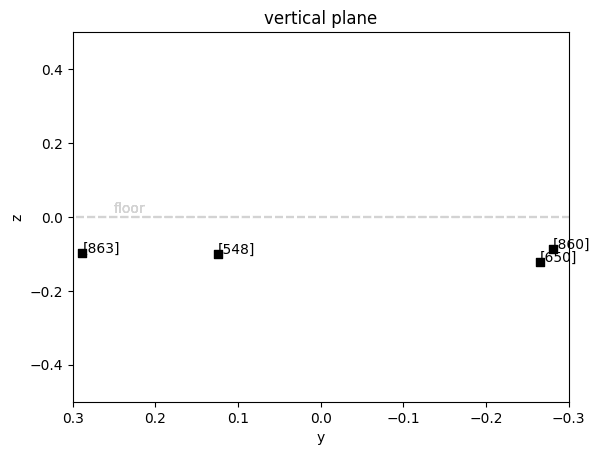

In [106]:
for i, c in enumerate(marker_tvecs_robot):
    id = ids[i]
    plt.scatter([c[1]], [c[2]], color="black", marker="s")
    plt.text(c[1], c[2], str(id))
    plt.ylabel("z")
    plt.xlabel("y")
    plt.xlim([-0.3, 0.3])
    plt.ylim([-0.5, 0.5])
    plt.axhline(0,-1,1, color="lightgray", ls="--")
    plt.text(0.25, 0.01, "floor", color="lightgray")

plt.gca().invert_xaxis()
plt.title("vertical plane")

Marker 548: [ 0.646  0.121 -0.089] ± [0.082 0.016 0.049] m
Marker 863: [ 0.634  0.281 -0.088] ± [0.067 0.031 0.041] m
Marker 860: [ 0.474 -0.273 -0.076] ± [0.038 0.024 0.031] m


Marker 650: [ 0.672 -0.251 -0.1  ] ± [0.114 0.044 0.067] m


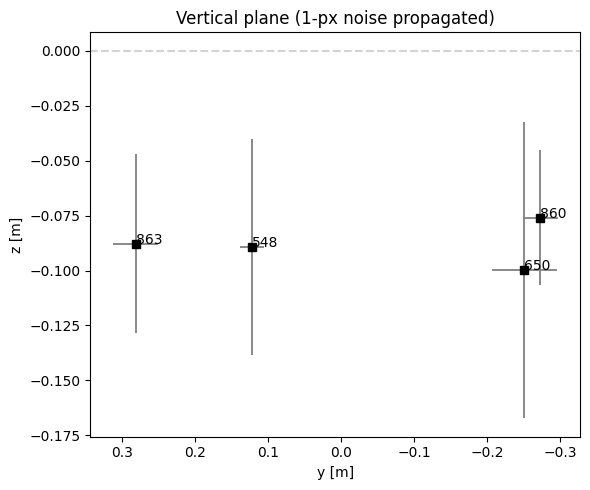

In [107]:
import numpy as np

# --- Transformation: camera → robot (from your setup) ---
x_offset_camera, y_offset_camera, z_offset_camera = 0.03, 0.0, 0.28
offset_camera_robot = np.array([x_offset_camera, y_offset_camera, z_offset_camera])

x_angle_camera, y_angle_camera, z_angle_camera = -140, 0, -90
rotation_camera_robot = np.radians([x_angle_camera, y_angle_camera, z_angle_camera])

def rotation_matrix(x_rotation, y_rotation, z_rotation):
    a, b, g = z_rotation, y_rotation, x_rotation
    return np.array([
        [np.cos(a)*np.cos(b), np.cos(a)*np.sin(b)*np.sin(g)-np.sin(a)*np.cos(g), np.cos(a)*np.sin(b)*np.cos(g)+np.sin(a)*np.sin(g)],
        [np.sin(a)*np.cos(b), np.sin(a)*np.sin(b)*np.sin(g)+np.cos(a)*np.cos(g), np.sin(a)*np.sin(b)*np.cos(g)-np.cos(a)*np.sin(g)],
        [-np.sin(b), np.cos(b)*np.sin(g), np.cos(b)*np.cos(g)]
    ])

def vectors_to_transformation_matrix(rotation, translation):
    rotation = np.asarray(rotation, float).reshape(3)
    translation = np.asarray(translation, float).reshape(3)
    R, _ = cv2.Rodrigues(rotation)
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = translation
    return T

def transformation_matrix_to_vectors(T):
    R = T[:3, :3]
    t = T[:3, 3]
    sy = np.sqrt(R[0,0]**2 + R[1,0]**2)
    if sy > 1e-6:
        x = np.arctan2(R[2,1], R[2,2])
        y = np.arctan2(-R[2,0], sy)
        z = np.arctan2(R[1,0], R[0,0])
    else:
        x = np.arctan2(-R[1,2], R[1,1])
        y = np.arctan2(-R[2,0], sy)
        z = 0
    return np.array([x, y, z]), t

R_cam_robot = rotation_matrix(*rotation_camera_robot)
T_camera_robot = np.eye(4)
T_camera_robot[:3, :3] = R_cam_robot
T_camera_robot[:3, 3] = offset_camera_robot

# --- Pixel-level Monte-Carlo function -------------------------------------
def mc_pose_from_pixel_noise(corners_2d, objp_marker, camera_matrix, dist_coeffs,
                             T_camera_robot, N_samples=500, sigma_px=1.0):
    """Propagate ±1 px detection noise to 3D position uncertainty."""
    samples_t_robot = []

    ok, rvec, tvec = cv2.solvePnP(objp_marker, corners_2d,
                                  camera_matrix, dist_coeffs,
                                  flags=cv2.SOLVEPNP_IPPE_SQUARE)
    if not ok:
        return None, None, None

    rvec = rvec.reshape(3)
    tvec = tvec.reshape(3)
    T_marker_cam = vectors_to_transformation_matrix(rvec, tvec)
    T_marker_robot = T_camera_robot @ T_marker_cam
    _, t_nom = transformation_matrix_to_vectors(T_marker_robot)

    for _ in range(N_samples):
        noisy_corners = corners_2d + np.random.normal(0, sigma_px, corners_2d.shape)
        ok, rvec_n, tvec_n = cv2.solvePnP(objp_marker, noisy_corners.astype(np.float32),
                                          camera_matrix, dist_coeffs,
                                          flags=cv2.SOLVEPNP_IPPE_SQUARE)
        if not ok:
            continue
        T_marker_cam_n = vectors_to_transformation_matrix(rvec_n, tvec_n)
        T_marker_robot_n = T_camera_robot @ T_marker_cam_n
        _, t_robot_n = transformation_matrix_to_vectors(T_marker_robot_n)
        samples_t_robot.append(t_robot_n)

    samples_t_robot = np.array(samples_t_robot)
    return t_nom, samples_t_robot.mean(axis=0), samples_t_robot.std(axis=0)
marker_tvecs_robot = []
marker_tvecs_robot_std = []

sigma_px = 4.0   # 1 px standard deviation of corner detection
N_samples = 500  # Monte-Carlo samples

for i, c in enumerate(corners):
    corners_2d = c[0].astype(np.float32)
    t_nom, t_mean, t_std = mc_pose_from_pixel_noise(
        corners_2d,
        marker_points.astype(np.float32),
        camera_matrix,
        distortion_coefficients,
        T_camera_robot,
        N_samples=N_samples,
        sigma_px=sigma_px
    )
    if t_mean is not None:
        marker_tvecs_robot.append(t_mean)
        marker_tvecs_robot_std.append(t_std)
        print(f"Marker {ids[i][0]}: {t_mean.round(3)} ± {t_std.round(3)} m")

# --- Plot y-z positions with error bars -----------------------------------
plt.figure(figsize=(6,5))
for i, c in enumerate(marker_tvecs_robot):
    std = marker_tvecs_robot_std[i]
    plt.errorbar(c[1], c[2], xerr=std[1], yerr=std[2],
                 fmt='s', color='black', ecolor='gray', elinewidth=1.3)
    plt.text(c[1], c[2], str(ids[i][0]))
plt.xlabel("y [m]")
plt.ylabel("z [m]")
plt.axhline(0, color="lightgray", ls="--")
plt.gca().invert_xaxis()
plt.title("Vertical plane (1-px noise propagated)")
plt.tight_layout()
plt.show()


We can see that, although all markers in the image are obviously placed directly on the floor, our estimated positions don't line uo perfectly with it. Some markers are estimated to "float" a bit above the floor, some are estimated to be slightly below it. This kind of imperfect measurement is something we must always expect when working with imperfect data. In our example, our camera calibration might not be completely optimal our images might be noisy, etc. Overall, however, these results aren't too bad and definitely still usable for our purposes. 

Next, we visualise where the markers are on the horizontal plane (i.e. the floor), relative to our robot. Because the robot is the reference point, it will always be at position (0,0).

Text(0.5, 1.0, 'horizontal plane')

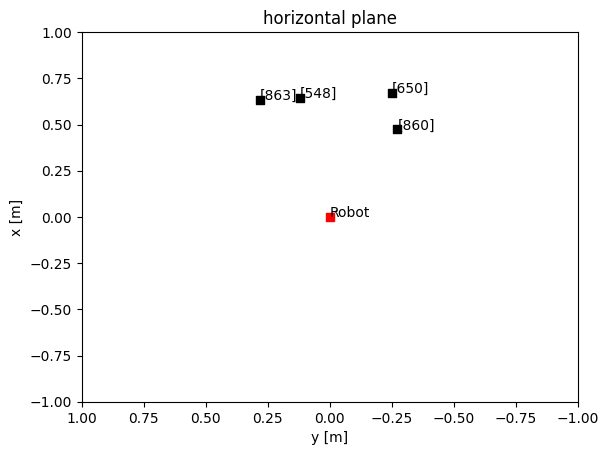

In [108]:
for i, c in enumerate(marker_tvecs_robot):
    id = ids[i]
    plt.scatter([c[1]], [c[0]], color="black", marker="s")
    plt.text(c[1], c[0], str(id))
    plt.ylabel("x [m]")
    plt.xlabel("y [m]")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.scatter([0], [0], color="red", marker="s")
plt.text(0, 0, "Robot")
plt.gca().invert_xaxis()
plt.title("horizontal plane")

### Projecting to world frame

Now that we know, where the markers are relative to our robot, we want to determine, where they are in our world coordinate frame. We will later need this to, for example, implement the landmark detection and localisation, as well as the SLAM algorithm for our robot.  
Let's assume that our robot started at the origin of the world coordinate frame. Now it has moved 40cm forwards and 25cm to the left, with a current heading o 30° to the right.


In [ ]:
# offset from robot to world frame
x_offset_world = 0.4
y_offset_world = 0.25
z_offset_world = 0

# angle from robot to world frame
x_angle_world = 0 # maybe switch x and z
y_angle_world = 0
z_angle_world = -30

offset_robot_world = np.array([x_offset_world,y_offset_world,z_offset_world]) 
rotation_robot_world = np.array([np.radians(x_angle_world), np.radians(y_angle_world), np.radians(z_angle_world)])

**Task:** Create transform matrix from robot to world frame.

In [117]:
### Your code here ###
R_robot_world = rotation_matrix(*rotation_robot_world)
T_robot_world = np.eye(4)
T_robot_world[:3, :3] = R_robot_world
T_robot_world[:3, 3] = offset_robot_world

**Task:** Create transform matrices for all markers in the robot coordinate frame, project them into the world coordinate frame, and transform them to rotation and translation vectors. Also print the id and world position for each marker.

In [118]:
marker_rvecs_world = []
marker_tvecs_world = []

for i, (rvec_r, tvec_r) in enumerate(zip(marker_rvecs_robot, marker_tvecs_robot)):
    T_marker_robot = vectors_to_transformation_matrix(rvec_r, tvec_r)
    T_marker_world = T_robot_world @ T_marker_robot
    rvec_w, tvec_w = transformation_matrix_to_vectors(T_marker_world)
    marker_rvecs_world.append(rvec_w)
    marker_tvecs_world.append(tvec_w)
    print(f"Marker ID {ids[i][0]}: world position = {tvec_w.round(3)} m")

Marker ID 548: world position = [ 0.898  0.678 -0.089] m
Marker ID 863: world position = [ 0.808  0.81  -0.088] m
Marker ID 860: world position = [ 0.947  0.251 -0.076] m
Marker ID 650: world position = [ 1.107  0.369 -0.1  ] m


Let's now again visualise our results. First, we plot where our markers are relative to the floor.  

Text(0.5, 1.0, 'vertical plane')

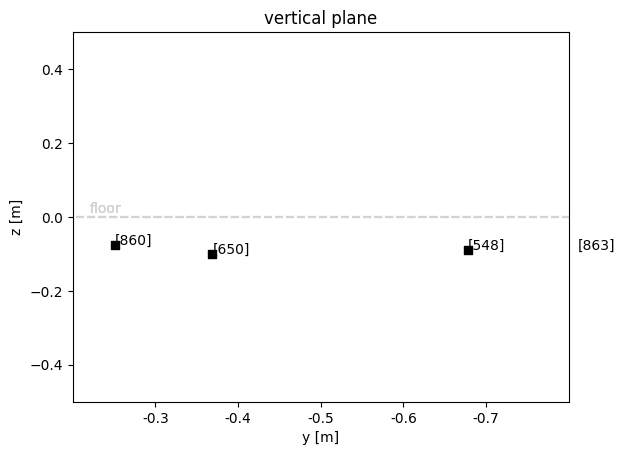

In [119]:
for i, c in enumerate(marker_tvecs_world):
    id = ids[i]
    # we mirror the y coordinate, because in the robot coordinate system y < 0 indicates a position to the right of the 
    # robot, but in the pyplot visualisation values < 0 are displayed on the left. The x ticks are adjusted accordingly.
    plt.scatter([c[1]], [c[2]], color="black", marker="s")
    plt.text(c[1], c[2], str(id))
    plt.ylabel("z [m]")
    plt.xlabel("y [m]")
    plt.xlim([0.2, 0.8])
    plt.ylim([-0.5, 0.5])
    plt.axhline(0,-1,1, color="lightgray", ls="--")
    plt.text(0.22, 0.01, "floor", color="lightgray")
    plt.xticks([0.3,0.4,0.5,0.6,0.7], [-0.3,-0.4,-0.5,-0.6,-0.7])
plt.title("vertical plane")

The measurement error from the previous pose estimation step obviously still exists, but overall our measurement is still good enough to use it, for example for navigation.

Finally, we again visualise the positions of the markers in the horizontal plane. This time we also visualise the position of our robot. This gives us essentially a section of our world map.

Text(0.5, 1.0, 'horizontal plane')

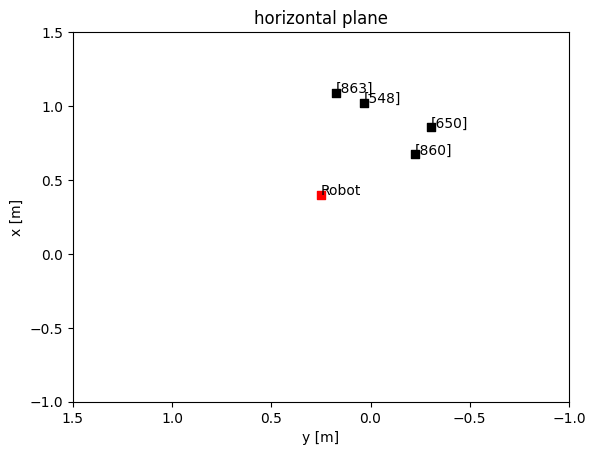

In [113]:
for i, c in enumerate(marker_tvecs_world):
    id = ids[i]
    plt.scatter([c[1]], [c[0]], color="black", marker="s")
    plt.text(c[1], c[0], str(id))
    plt.ylabel("x [m]")
    plt.xlabel("y [m]")
plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)
plt.gca().invert_xaxis()
plt.scatter([y_offset_world], [x_offset_world], color="red", marker="s")
plt.text(y_offset_world, x_offset_world, "Robot")
plt.title("horizontal plane")